In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
from dataclasses import dataclass, field
from typing import Callable, List, Tuple, Union

import lightgbm as lgb
import catboost as cb
from statsforecast.models import Naive, SeasonalNaive, AutoARIMA

#from tsforge import Recipe, make_mlf_workflow, make_sf_workflow, make_custom_workflow
#import tsforge
from tsforge import Recipe, WorkflowManager, make_mlf_workflow, make_sf_workflow, make_custom_workflow, make_ensemble, plot_cv_results, plot_cv_plan
from tsforge.evaluation import accuracy_table

# Set environment variable to display ID as a separate column in the leaderboard - Nixtla environment Variable
import os
os.environ["NIXTLA_ID_AS_COL"] = "1"

from tsforge.display import enable_notebook_style, style_leaderboard
enable_notebook_style()



c:\Users\tacke\Documents\GitHub\tsforge\.venv\Lib\site-packages\fs\__init__.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__("pkg_resources").declare_namespace(__name__)  # type: ignore
c:\Users\tacke\Documents\GitHub\tsforge\.venv\Lib\site-packages\statsforecast\core.py:27: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
#train_df = pd.read_parquet('../data/input/processed/01_train_df.parquet')

# when working locally
train_df = pd.read_parquet(r"C:\Users\tacke\Documents\GitHub\forecast_academy\data\input\processed\01_train_df.parquet")



In [4]:
# fill sales with 0
train_df1 = train_df.copy()
train_df1['sales'] = train_df1['sales'].fillna(0)

# Fill events with 0
# 
train_df1 = train_df1.drop(['event_name_1', 'event_type_1', 'event_name_2', 'event_type_2','snap_CA','snap_TX','snap_WI'], axis=1)
train_df1.head(2)

,unique_id,date,sales,item_id,dept_id,cat_id,store_id,state_id
0,HOBBIES_1_001_CA_1,2013-07-18,1.0,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA
1,HOBBIES_1_001_CA_1,2013-07-19,0.0,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA


In [5]:
train_df1.columns

Index(['unique_id', 'date', 'sales', 'item_id', 'dept_id', 'cat_id',
       'store_id', 'state_id'],
      dtype='object')

In [6]:

# Recipe (cast to category for MLForecast/LightGBM)
mlf_recipe=Recipe().step_as_category(["item_id","dept_id","cat_id","store_id","state_id"])

# Workflows
# not catboost explicitly wants cat_columns, so we inject them automatically if missing for simplicity here, but might be good to talk through in training.
# wf1=make_mlf_workflow("Short_Lags",
#                       models=[lgb.LGBMRegressor(),cb.CatBoostRegressor(verbose=0)],
#                       lags=[7,14,28],
#                       date_features=["dayofweek","month"],
#                       static_features=["item_id","dept_id","cat_id","store_id","state_id"],
#                       recipe=mlf_recipe)

wf4 = make_mlf_workflow(
    "Expanded_Lags",
    models=[lgb.LGBMRegressor(verbose=-1)],
    lags=[7, 14],
    freq='D',
    date_features=["dayofweek", "month"],
    static_features=["item_id","dept_id","cat_id","store_id","state_id"],
    recipe=mlf_recipe,
    with_intervals=True,
    intervals_h=28,
    intervals_windows=3,                
    intervals_method="conformal_distribution"  
)

wf2=make_sf_workflow("Classical",
                     models = [Naive(),SeasonalNaive(season_length=7)],
                     )

wf_ens1 = make_ensemble("Avg Ensemble", [wf2, wf4], method="mean")

wf_ens2 = make_ensemble("Weighted Ensemble",
    members=[(wf2, "SeasonalNaive"), (wf4, "LGBMRegressor")],
    method="weighted", weights=[0.3, 0.7])

# Using custom function
#wf3=make_custom_workflow("Custom_Avg",seasonal_avg)

#workflows=[wf1,wf2,wf3,wf4]
workflows=[wf2,wf4,wf_ens1,wf_ens2]

# Run backtest
manager=WorkflowManager(workflows)
cv_results=manager.cross_validation(train_df1,
                                     h=28, 
                                     n_windows = 2,
                                     level=[80,95])


In [7]:
# wf4 = make_mlf_workflow(
#     "Expanded_Lags",
#     models=[lgb.LGBMRegressor()],
#     lags=[7,14],
#     date_features=["dayofweek","month"],
#     static_features=["item_id","dept_id","cat_id","store_id","state_id"],
#     freq="D",  # or "W" if your data is weekly
#     with_intervals=True,
#     intervals_h=28,
#     intervals_windows=3,
#     intervals_method="conformal_distribution"
# )

# manager_final = WorkflowManager([wf4])
# manager_final._pred_cache.clear()

# preds = manager_final.forecast(train_df1, h=28, level=[80,95])
# print(preds.head())
# print(preds.columns)

In [8]:
cv_results.head(2)

,unique_id,date,cutoff,sales,yhat,lo-80,lo-95,hi-80,hi-95,model,workflow,engine,pi_status
0,HOBBIES_1_001_CA_1,2016-03-28,2016-03-27,1.0,1.0,-0.480561,-1.264322,2.480561,3.264322,Naive,Classical,statsforecast,NaN
1,HOBBIES_1_001_CA_1,2016-03-29,2016-03-27,0.0,1.0,-1.093829,-2.202235,3.093829,4.202235,Naive,Classical,statsforecast,NaN


In [16]:
scores = accuracy_table(cv_results, 
                        train_df1, 
                        mode='aggregate',
                        include_interval_metrics=True, 
                        #metrics = ['mae','bias','accuracy','coverage']
                        )
scores

,workflow,engine,model,mae,rmse,mape,smape,wape,accuracy,bias,...,forecast_bias,mase,coverage_80,width_80,winkler_80,cwc_80,coverage_95,width_95,winkler_95,cwc_95
0,Avg Ensemble,ensemble,Avg Ensemble,0.942360,1.926226,76.091632,116.947022,1.042610,-0.042610,0.067430,...,1.074603,1.983736,0.971880,10.438404,10.740950,-2.154708,0.992938,15.964161,16.300325,-13.646405
1,Classical,statsforecast,Naive,1.052268,2.229906,90.561713,81.141041,1.164492,-0.164492,0.199763,...,1.221068,1.107320,0.979429,13.406657,13.631225,-2.480593,0.993948,20.503713,20.781815,-17.708308
2,Classical,statsforecast,SeasonalNaive,0.932681,2.005801,82.889287,77.560486,1.032151,-0.032151,-0.049247,...,0.945500,0.981477,0.964319,7.467771,7.848420,-1.676647,0.991924,11.420970,11.815335,-9.544235
3,Expanded_Lags,mlforecast,LGBMRegressor,0.875057,1.599588,54.486355,149.440089,0.968146,0.031854,0.043925,...,1.048598,0.916299,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Expanded_Lags,mlforecast,pi_status,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Weighted Ensemble,ensemble,Weighted Ensemble,0.863221,1.621297,58.937254,152.103715,0.955052,0.044948,0.015956,...,1.017654,0.908571,0.752854,2.240570,5.270985,-1.110081,0.850106,3.426656,10.552437,-1.473406


In [10]:
import mlforecast
print(mlforecast.__version__)

0.13.4


In [11]:
cv_results.head()

,unique_id,date,cutoff,sales,yhat,lo-80,lo-95,hi-80,hi-95,model,workflow,engine,pi_status
0,HOBBIES_1_001_CA_1,2016-03-28,2016-03-27,1.0,1.0,-0.480561,-1.264322,2.480561,3.264322,Naive,Classical,statsforecast,NaN
1,HOBBIES_1_001_CA_1,2016-03-29,2016-03-27,0.0,1.0,-1.093829,-2.202235,3.093829,4.202235,Naive,Classical,statsforecast,NaN
2,HOBBIES_1_001_CA_1,2016-03-30,2016-03-27,0.0,1.0,-1.564407,-2.921921,3.564407,4.921921,Naive,Classical,statsforecast,NaN
3,HOBBIES_1_001_CA_1,2016-03-31,2016-03-27,0.0,1.0,-1.961122,-3.528645,3.961122,5.528645,Naive,Classical,statsforecast,NaN
4,HOBBIES_1_001_CA_1,2016-04-01,2016-03-27,0.0,1.0,-2.310635,-4.063179,4.310635,6.063179,Naive,Classical,statsforecast,NaN


In [12]:
cv_results[(cv_results.engine == 'mlforecast')].pi_status.unique()

array(['pi_failed', 'short_series'], dtype=object)

In [13]:
cv_results.model.unique()

array(['Naive', 'SeasonalNaive', 'LGBMRegressor', 'pi_status',
       'Avg Ensemble', 'Weighted Ensemble'], dtype=object)

In [14]:
cv_results[(cv_results.pi_status !='short_series') & (cv_results.engine == 'mlforecast')].head(2)

,unique_id,date,cutoff,sales,yhat,lo-80,lo-95,hi-80,hi-95,model,workflow,engine,pi_status
541632,HOBBIES_1_001_CA_1,2016-03-28,2016-03-27,1.0,0.475475,NaN,NaN,NaN,NaN,LGBMRegressor,Expanded_Lags,mlforecast,pi_failed
541633,HOBBIES_1_001_CA_1,2016-03-29,2016-03-27,0.0,0.678482,NaN,NaN,NaN,NaN,LGBMRegressor,Expanded_Lags,mlforecast,pi_failed


In [15]:
cv_results[(cv_results.pi_source =='') & (cv_results.engine == 'mlforecast') & (cv_results.model != 'pi_source')].head(2)

AttributeError: 'DataFrame' object has no attribute 'pi_source'

In [ ]:
cv_results.query("engine == 'mlforecast'").tail()

,unique_id,date,cutoff,sales,yhat,lo-80,lo-95,hi-80,hi-95,model,workflow,engine,pi_source
1083259,HOUSEHOLD_1_405_CA_2,2016-05-18,2016-04-24,3.0,NaN,NaN,NaN,NaN,NaN,pi_source,Expanded_Lags,mlforecast,flat_short_series
1083260,HOUSEHOLD_1_405_CA_2,2016-05-19,2016-04-24,1.0,NaN,NaN,NaN,NaN,NaN,pi_source,Expanded_Lags,mlforecast,flat_short_series
1083261,HOUSEHOLD_1_405_CA_2,2016-05-20,2016-04-24,3.0,NaN,NaN,NaN,NaN,NaN,pi_source,Expanded_Lags,mlforecast,flat_short_series
1083262,HOUSEHOLD_1_405_CA_2,2016-05-21,2016-04-24,3.0,NaN,NaN,NaN,NaN,NaN,pi_source,Expanded_Lags,mlforecast,flat_short_series
1083263,HOUSEHOLD_1_405_CA_2,2016-05-22,2016-04-24,2.0,NaN,NaN,NaN,NaN,NaN,pi_source,Expanded_Lags,mlforecast,flat_short_series


In [ ]:
cv_results.query("engine == 'ensemble'").head()

,unique_id,date,cutoff,sales,yhat,lo-80,lo-95,hi-80,hi-95,model,workflow,engine,pi_source
1083264,HOBBIES_1_001_CA_1,2016-03-28,2016-03-27,1.0,0.730727,-0.009553,-0.401434,1.471007,1.862888,Avg Ensemble,Avg Ensemble,ensemble,NaN
1083265,HOBBIES_1_001_CA_1,2016-03-28,2016-03-27,1.0,1.000000,-0.480561,-1.264322,2.480561,3.264322,Avg Ensemble,Avg Ensemble,ensemble,NaN
1083266,HOBBIES_1_001_CA_1,2016-03-29,2016-03-27,0.0,0.814915,-0.232000,-0.786203,1.861830,2.416033,Avg Ensemble,Avg Ensemble,ensemble,NaN
1083267,HOBBIES_1_001_CA_1,2016-03-29,2016-03-27,0.0,1.000000,-1.093829,-2.202235,3.093829,4.202235,Avg Ensemble,Avg Ensemble,ensemble,NaN
1083268,HOBBIES_1_001_CA_1,2016-03-30,2016-03-27,0.0,0.814915,-0.467288,-1.146046,2.097118,2.775876,Avg Ensemble,Avg Ensemble,ensemble,NaN


In [ ]:
scores.columns

Index(['workflow', 'engine', 'model', 'accuracy', 'bias', 'coverage_80',
       'coverage_95', 'mae'],
      dtype='object')

[Info] Multiple series detected (4836). Showing first: HOBBIES_1_001_CA_1


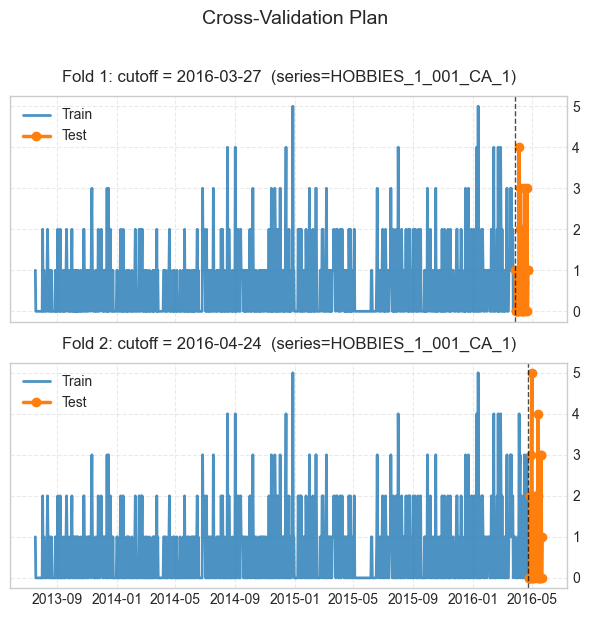

In [ ]:
#from tsforge import plot_cv_plan

plot_cv_plan(manager, train_df1) 

In [ ]:
scores

,workflow,engine,model,accuracy,bias,coverage_80,coverage_95,mae
0,Avg Ensemble,ensemble,Avg Ensemble,-0.043226,0.068295,0.944036,0.981562,0.942689
1,Classical,statsforecast,Naive,-0.164492,0.199763,0.979429,0.993948,1.052268
2,Classical,statsforecast,SeasonalNaive,-0.032151,-0.049247,0.964319,0.991924,0.932681
3,Expanded_Lags,mlforecast,LGBMRegressor,0.030650,0.047407,0.000000,0.000000,0.875932
4,Expanded_Lags,mlforecast,pi_source,NaN,NaN,NaN,NaN,NaN
5,Weighted Ensemble,ensemble,Weighted Ensemble,0.043815,0.018411,0.751470,0.890302,0.864035


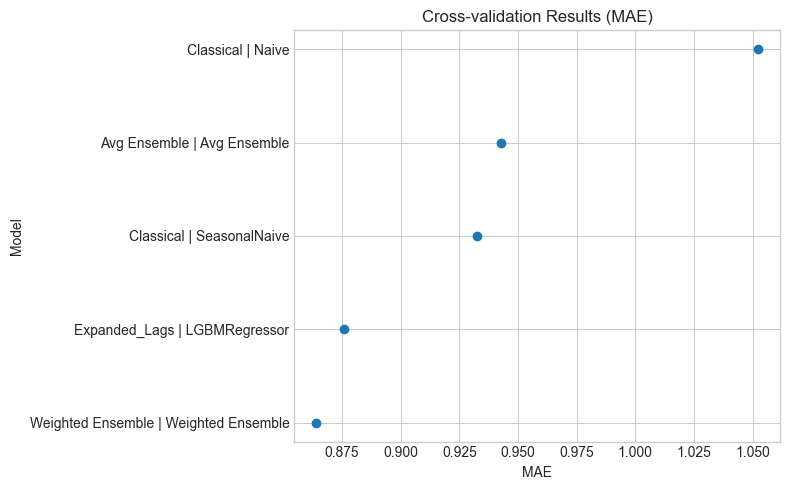

In [ ]:
plot_cv_results(scores, metric="mae")

In [ ]:
# leaderboard=manager.cross_validation(train_df1,h=1, n_windows=2 , mode = 'folds')
# leaderboard


In [ ]:
# after CV + evaluation you picked wf_ens1
manager_final = WorkflowManager([wf4])
final_preds = manager_final.forecast(train_df1, h=28, level=[80,95])

C:\Users\tacke\Documents\GitHub\tsforge\src\tsforge\workflows\manager.py:235: UserWarning: ⚠️ 1 series too short for PI (need≈98). Using flat intervals for these series.
  warnings.warn(


In [ ]:
final_preds.columns

Index(['unique_id', 'date', 'pi_source', 'yhat', 'lo-95', 'lo-80', 'hi-80',
       'hi-95', 'model', 'workflow', 'engine'],
      dtype='object')

In [ ]:
final_preds.unique_id.unique()

['HOBBIES_1_001_CA_1', 'HOBBIES_1_001_CA_2', 'HOBBIES_1_001_TX_1', 'HOBBIES_1_002_CA_1', 'HOBBIES_1_002_CA_2', ..., 'HOUSEHOLD_2_515_TX_1', 'HOUSEHOLD_2_516_CA_1', 'HOUSEHOLD_2_516_CA_2', 'HOUSEHOLD_2_516_TX_1', 'HOUSEHOLD_1_405_CA_2']
Length: 4836
Categories (4836, object): ['HOBBIES_1_001_CA_1', 'HOBBIES_1_001_CA_2', 'HOBBIES_1_001_TX_1', 'HOBBIES_1_002_CA_1', ..., 'HOUSEHOLD_2_515_TX_1', 'HOUSEHOLD_2_516_CA_1', 'HOUSEHOLD_2_516_CA_2', 'HOUSEHOLD_2_516_TX_1']

In [ ]:
train_df1[train_df1.unique_id=='HOUSEHOLD_2_516_TX_1'].head()

,unique_id,date,sales,item_id,dept_id,cat_id,store_id,state_id
6140163,HOUSEHOLD_2_516_TX_1,2012-06-23,1.0,HOUSEHOLD_2_516,HOUSEHOLD_2,HOUSEHOLD,TX_1,TX
6140164,HOUSEHOLD_2_516_TX_1,2012-06-24,0.0,HOUSEHOLD_2_516,HOUSEHOLD_2,HOUSEHOLD,TX_1,TX
6140165,HOUSEHOLD_2_516_TX_1,2012-06-25,0.0,HOUSEHOLD_2_516,HOUSEHOLD_2,HOUSEHOLD,TX_1,TX
6140166,HOUSEHOLD_2_516_TX_1,2012-06-26,0.0,HOUSEHOLD_2_516,HOUSEHOLD_2,HOUSEHOLD,TX_1,TX
6140167,HOUSEHOLD_2_516_TX_1,2012-06-27,0.0,HOUSEHOLD_2_516,HOUSEHOLD_2,HOUSEHOLD,TX_1,TX


In [ ]:
final_preds[final_preds.unique_id=='HOUSEHOLD_2_516_TX_1'].head()

,unique_id,date,pi_source,yhat,lo-95,lo-80,hi-80,hi-95,model,workflow,engine
135352,HOUSEHOLD_2_516_TX_1,2016-05-23,conformal,0.115369,-0.671563,-0.384631,0.615369,0.902302,LGBMRegressor,Expanded_Lags,mlforecast
135353,HOUSEHOLD_2_516_TX_1,2016-05-24,conformal,0.105100,-0.006244,-0.006244,0.216444,0.216444,LGBMRegressor,Expanded_Lags,mlforecast
135354,HOUSEHOLD_2_516_TX_1,2016-05-25,conformal,0.105100,-0.113880,-0.067751,0.277950,0.324080,LGBMRegressor,Expanded_Lags,mlforecast
135355,HOUSEHOLD_2_516_TX_1,2016-05-26,conformal,0.105100,-0.113880,-0.067751,0.277950,0.324080,LGBMRegressor,Expanded_Lags,mlforecast
135356,HOUSEHOLD_2_516_TX_1,2016-05-27,conformal,0.104336,-0.139478,-0.082779,0.291452,0.348151,LGBMRegressor,Expanded_Lags,mlforecast


In [ ]:
final_preds.columns

Index(['unique_id', 'date', 'pi_source', 'yhat', 'lo-95', 'lo-80', 'hi-80',
       'hi-95', 'model', 'workflow', 'engine'],
      dtype='object')